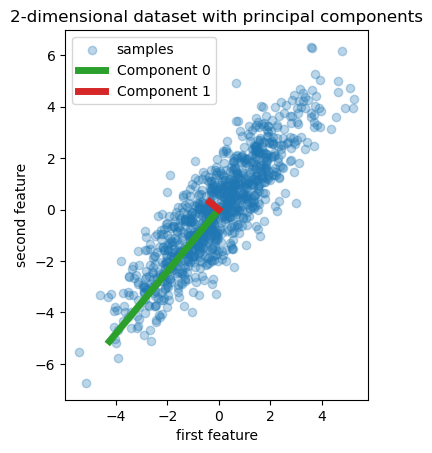

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

rng = np.random.RandomState(1)
n_samples = 1000
cov = [[3, 3], [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
pca = PCA(n_components=2).fit(X)

plt.scatter(X[:, 0], X[:, 1], alpha=.3, label='samples')
for i, (comp,var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

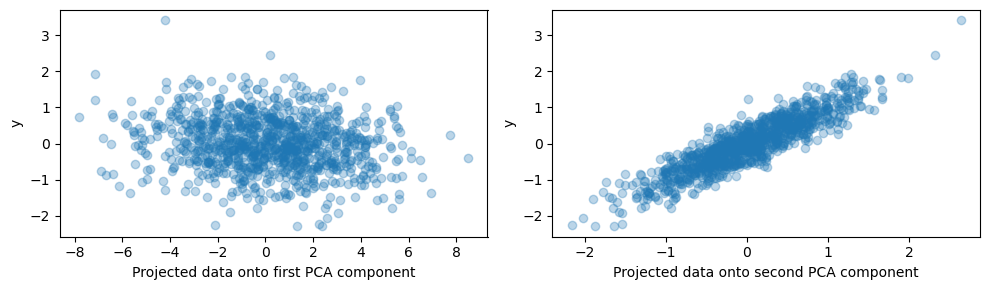

In [5]:
y = X.dot(pca.components_[1] + 0.1 * rng.randn(2)) + 0.3 * rng.randn(n_samples)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(X.dot(pca.components_[0]), y, alpha=.3)
axes[0].set(xlabel="Projected data onto first PCA component",
            ylabel='y')
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=.3)
axes[1].set(xlabel="Projected data onto second PCA component",
            ylabel='y')
fig.tight_layout()
plt.show()

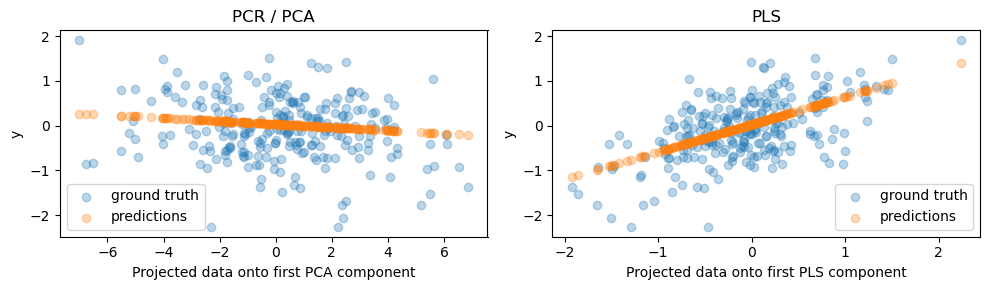

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

pca = pcr.named_steps['pca']  

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test)[:, 0], pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test)[:, 0], pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()
fig.tight_layout()
plt.show()

In [7]:
import cvxpy as cp
class PLS1():
    def __init__(self, n_components,  ) -> None:
        self.components = n_components
    
    def fit(self,X,y):
        n_samples, n_features = X.shape
        n_components = self.components
        # Center data
        X_mean = X.mean(axis=0)
        y_mean = y.mean(axis=0)
        X_centered = X - X_mean
        y_centered = y - y_mean
        # Scaling data
        X_std = X.std(axis=0, ddof=1)
        y_std = y.std(axis=0, ddof=1)
        X_scaled = X_centered / X_std
        y_scaled = y_centered / y_std
        # Regression
        w = cp.Variable((n_features, n_components))
        c = cp.Variable((n_components,))
        t = cp.Variable((n_samples, n_components))
        u = cp.Variable((n_samples, n_components))
        v = cp.Variable((n_samples, n_components))
        objective = cp.Minimize(cp.sum_squares(y_scaled - t @ c))
        constraints = [t == X_scaled @ w,
                        u == X_scaled @ w,
                        v == y_scaled @ c,
                        cp.norm(w, axis=0) <= 1]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        self.w = w.value
        self.c = c.value
        self.t = t.value
        self.u = u.value
        self.v = v.value
        self.X_mean = X_mean
        self.y_mean = y_mean
        self.X_std = X_std
        self.y_std = y_std
        return self
    
    def transform(self,X):
        X_centered = X - self.X_mean
        X_scaled = X_centered / self.X_std
        return X_scaled @ self.w
    
    def predict(self,X):
        X_centered = X - self.X_mean
        X_scaled = X_centered / self.X_std
        return X_scaled @ self.w @ self.c * self.y_std + self.y_mean
    
    def score(self,X,y):
        y_pred = self.predict(X)
        return 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
    
pls1 = PLS1(n_components=1)
pls1.fit(X_train,y_train)
        

ValueError: Incompatible dimensions (1, 750) (1, 1)